In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gate_estimation.resource_analysis import *
from gate_estimation.optimization_utils import *
from benchmark_utils import *
from azure.quantum.target.microsoft import ErrorBudgetPartition

In [2]:
# from Shor_Sequential_QFT import *
# shor = shor_factoring(21)
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)
circ = build_lattice_hamiltonian(num_spins=10**2, Dimension=(10,10), model='Ising')
# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=50)

cut_circuits, metadata = find_cuts(circ, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]} and classical runtime {metadata["sampling_overhead"]/10**15}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)

Found solution using 100 cuts with a sampling overhead of 9.712482128775505e+17 and classical runtime 971.2482128775505.
Lowest cost solution found: False.


In [2]:
circuit = build_lattice_hamiltonian(num_spins=10**2, Dimension=(10,10), model='Ising')
# circuit.draw('mpl', scale=0.5)

In [4]:
circuit.depth()

365

In [3]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=80)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]} and classical runtime {metadata["sampling_overhead"]/10**15}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
# for cut in metadata["cuts"]:
#     print(f"{cut[0]} at circuit instruction index {cut[1]}")
# cut_circuit.draw("mpl", scale=0.8, fold=-1)

Found solution using 100 cuts with a sampling overhead of 9.712482128775505e+17 and classical runtime 971.2482128775505.
Lowest cost solution found: False.


In [3]:
from qiskit_addon_cutting import cut_wires,partition_problem
qc_w_ancilla = cut_wires(cut_circuits)
partitioned_problem = partition_problem(circuit=qc_w_ancilla)
subcircuit= partitioned_problem.subcircuits
subcircuits = [cuts_filter(s) for s in subcircuit.values()]
# subcircuits[0].draw("mpl", style="iqp", scale=0.5)

In [7]:
# circuit.count_ops()

In [5]:
from qsharp.estimator import EstimatorParams
from qsharp.interop.qiskit import ResourceEstimatorBackend
params = EstimatorParams()
params.error_budget = 0.01
params.constraints.max_t_factories = 1
backend = ResourceEstimatorBackend()
job = backend.run(circuit, params)
r = job.result()
Q = r['physicalCounts']['physicalQubits']
T = r['physicalCounts']['runtime']*1e-9
print('\n', 'total physical qubits required: ', Q, '\n', 'total runtime', T)


 total physical qubits required:  146460 
 total runtime 2.4876848000000003


In [9]:
estimate_resources(circuit)

{'LogicalQubits': 100,
 'T': 0,
 'cnot': 3600,
 'Rotations': 2300,
 'Toffoli': 0,
 'Rotation_layer': 23.0}

In [5]:
print(subcircuit[0].num_qubits,subcircuit[1].num_qubits)

50 50


In [7]:
from qsharp.estimator import EstimatorParams
from qsharp.interop.qiskit import ResourceEstimatorBackend
for i in range(1,6):
    print(i)
    params = EstimatorParams()
    params.error_budget = 0.01
    params.constraints.max_t_factories = 1
    backend = ResourceEstimatorBackend()
    job = backend.run(circ, params)
    r = job.result()
    Q = r['physicalCounts']['physicalQubits']
    T = r['physicalCounts']['runtime']*1e-9
    # print('\n', 'total physical qubits required: ', Q, '\n', 'total runtime', T)
    params1 = EstimatorParams()
    params2 = EstimatorParams()
    params1.constraints.max_t_factories = i
    params2.constraints.max_t_factories = i
    params1.error_budget = 0.01*0.5
    job1 = backend.run(subcircuit[0], params1)
    r1 = job1.result()
    params2.error_budget = 0.01*0.5
    job2 = backend.run(subcircuit[1], params2)
    r2 = job2.result()
    print(1-max(r1['physicalCounts']['physicalQubits'],r2['physicalCounts']['physicalQubits'])/Q)
    print(r1['physicalCounts']['runtime']*1e-9+r2['physicalCounts']['runtime']*1e-9/T)
        # print('\n', 'subcircuit-1 : physical qubits--', r1['physicalCounts']['physicalQubits'], 'runtime (in microsec)--', r1['physicalCounts']['runtime']*1e-3)
        # print('\n', 'subcircuit-2 : physical qubits--', r2['physicalCounts']['physicalQubits'], 'runtime (in microsec)--', r2['physicalCounts']['runtime']*1e-3)



1
0.43016523282807595
1.6680227507189014
2
0.33785333879557555
0.8340161420920851
3
0.24554144476307527
0.556039361790529
4
0.05589239382766631
0.3528531773131387
5
0.16666666666666663
0.33360679331207876


In [ ]:
1.67-0.33

In [10]:
# Q_approx = PhysicalParameters.make_beverland_et_al(circuit, error_budget=[0.01/3]*3).Q
# ratio = Q_approx/Q
# q = []
# sub_error_budget = [(0.01/20*e, 0.01-0.01/20*e) for e in range(1,20)]
# for (e1, e2) in sub_error_budget:
#     Q1 = PhysicalParameters.make_beverland_et_al(subcircuit[0], error_budget = [e1/3]*3).Q
#     Q2 = PhysicalParameters.make_beverland_et_al(subcircuit[1], error_budget = [e2/3]*3).Q 
#     q.append(max(Q1, Q2)/ratio)

# plt.scatter([e1 for (e1,e2) in sub_error_budget], q, label='subcircuits')
# plt.plot([0, 0.01], [Q, Q], 'r--', label='original circuit')
# plt.legend()
# plt.xlabel('Error budget for the first subcircuit')
# plt.ylabel('Number of Physical qubits')
# plt.show()


In [11]:
# Q_approx = PhysicalParameters.make_beverland_et_al(circuit, error_budget=[0.01/3]*3).Q
# q = []
# sub_error1 = []
# # sol = {}
# sol_q = Q_approx
# sol_e = None
# partition = error_budget_partition(0.01, len(subcircuits)*3)
# sub_error_budget = partition + [l[::-1] for l in partition]
# for e in sub_error_budget:
#     Q1 = PhysicalParameters.make_beverland_et_al(subcircuit[0], error_budget = [i/5000 for i in e[:3]]).Q
#     Q2 = PhysicalParameters.make_beverland_et_al(subcircuit[1], error_budget = [i/5000 for i in e[3:]]).Q 
#     m = max(Q1, Q2)
#     q.append(m/ratio)
#     sub_error1.append(sum(e[:3])/5000)
#     if sol_q > m:
#         sol_q = m
#         sol_e = e
        
# print(sol_q, sol_e)
# plt.scatter(sub_error1, [i/ratio for i in q], label='subcircuits')
# plt.plot([0, 0.01], [Q, Q], 'r--', label='original circuit')
# plt.legend()
# # plt.ylim([min(q)-1000, Q_approx+1000])
# plt.xlabel('Error budget for the first subcircuit')
# plt.ylabel('Number of Physical qubits required')
# plt.show()


In [6]:
partition = list(accel_asc(20))
sub_part = []
for p in partition:
    if len(p) == 2:
        sub_part.append(list(p))
sub_parts = []
for s in sub_part:
    for l in permutations(s):
        sub_parts.append(l)
e = list(set(sub_parts))

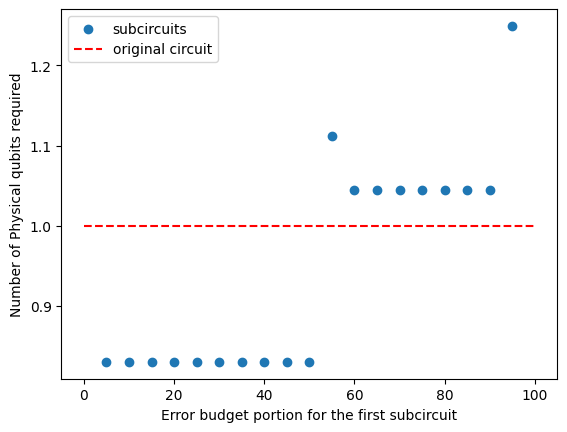

In [7]:
params1 = EstimatorParams()
params2 = EstimatorParams()
params1.constraints.max_t_factories = 1
params2.constraints.max_t_factories = 1

q = []
t = []  
for e1, e2 in e:
    params1.error_budget = e1/2e3
    job1 = backend.run(subcircuit[0], params1)
    r1 = job1.result()
    params2.error_budget = e2/2e3
    job2 = backend.run(subcircuit[1], params2)
    r2 = job2.result()
    q.append(max(r1['physicalCounts']['physicalQubits'],r2['physicalCounts']['physicalQubits']))
    t.append(r1['physicalCounts']['runtime']*1e-9+r2['physicalCounts']['runtime']*1e-9)
    # print('\n', 'subcircuit-1 : physical qubits--', r1['physicalCounts']['physicalQubits'], 'runtime (in microsec)--', r1['physicalCounts']['runtime']*1e-3)
    # print('\n', 'subcircuit-2 : physical qubits--', r2['physicalCounts']['physicalQubits'], 'runtime (in microsec)--', r2['physicalCounts']['runtime']*1e-3)

plt.scatter([5*e1 for (e1,e2) in e], [i/Q for i in q], label='subcircuits')
plt.plot([0, 100], [1, 1], 'r--', label='original circuit')
plt.legend()
plt.xlabel('Error budget portion for the first subcircuit')
plt.ylabel('Number of Physical qubits required')
plt.show()


In [9]:
[i/Q for i in q]

[1.0447494196367608,
 0.830301788884337,
 0.830301788884337,
 1.0447494196367608,
 1.0447494196367608,
 0.830301788884337,
 0.830301788884337,
 1.0447494196367608,
 0.830301788884337,
 1.0447494196367608,
 1.0447494196367608,
 0.830301788884337,
 1.2490372798033593,
 0.830301788884337,
 1.112344667486003,
 0.830301788884337,
 0.830301788884337,
 1.0447494196367608,
 0.830301788884337]

In [14]:
partition = list(accel_asc(20))
sub_part = []
for p in partition:
    if len(p) == 3:
        sub_part.append(list(p))
sub_parts = []
for s in sub_part:
    for l in permutations(s):
        sub_parts.append(l)
es = list(set(sub_parts))

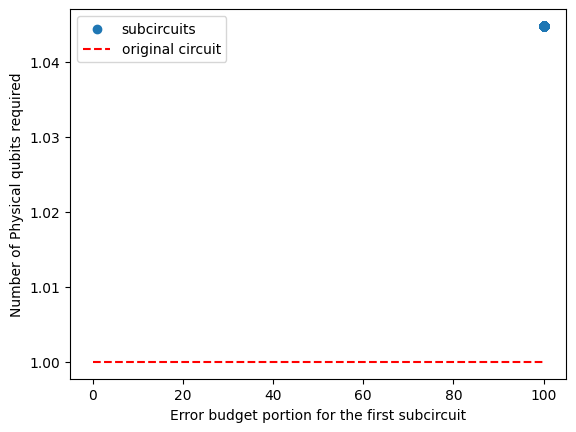

In [18]:
# params1 = EstimatorParams()
# params2 = EstimatorParams()
# params1.constraints.max_t_factories = 1
# params2.constraints.max_t_factories = 1

# qs = []
# ts = []  
# for e1, e2, e3 in es:
#     params1.error_budget = ErrorBudgetPartition(e1/1e4, e2/1e4, e3/1e4) 
#     job1 = backend.run(subcircuit[0], params1)
#     r1 = job1.result()
#     params2.error_budget = ErrorBudgetPartition(8/3e3, 8/3e3, 8/3e3) 
#     job2 = backend.run(subcircuit[1], params2)
#     r2 = job2.result()
#     qs.append(max(r1['physicalCounts']['physicalQubits'],r2['physicalCounts']['physicalQubits']))
#     ts.append(r1['physicalCounts']['runtime']*1e-9+r2['physicalCounts']['runtime']*1e-9)

plt.scatter([5*(e1+e2+e3) for (e1,e2,e3) in es], [i/Q for i in qs], label='subcircuits')
plt.plot([0, 100], [1, 1], 'r--', label='original circuit')
plt.legend()
plt.xlabel('Error budget portion for the first subcircuit')
plt.ylabel('Number of Physical qubits required')
plt.show()


In [ ]:
# # Define angles for radar plot (hexagon has 6 sides)
# num_vars = 6
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# angles += angles[:1]  # Complete the loop


# # Create radar chart
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # Plot each combination and corresponding function size
# for comb in es:
#     values = list(comb)
#     values += values[:1]  # Repeat the first value to close the polygon
#     function_value = error_gen(*comb)

#     # Normalize the values for plotting
#     normalized_values = [v / 100.0 for v in values]

#     # Plot
#     ax.fill(angles, normalized_values, alpha=0.25)
#     ax.plot(angles, normalized_values, linewidth=2, label=f'f={function_value:.2f}')

# # Customize plot
# ax.set_yticklabels([])  # Hide radial labels
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels([f'e{i+1}' for i in range(num_vars)])

# plt.title('Function size with different combinations of variables (e1 to e6)')

# plt.show()
